In [37]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import numpy as np


def transform_to_utm(gdf):
  centroid = gdf.geometry.unary_union.centroid
  utm_zone = int((centroid.x + 180) / 6) + 1
  utm_crs = f"EPSG:326{utm_zone:02d}" if centroid.y >= 0 else f"EPSG:327{utm_zone:02d}"

  return gdf.to_crs(utm_crs)

def trasform_to_gdf(json):
  df = pd.read_json(json)
  df['latitude'] = df['coordinates'].apply(lambda x: x['latitude'])
  df['longitude'] = df['coordinates'].apply(lambda x: x['longitude'])

  # Создаем геометрию
  geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
  gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

  gdf = gdf.drop(['coordinates'], axis=1)
  return gdf

cafe_gdf = trasform_to_gdf("data/basman_cafes.json")
cafes_utm = transform_to_utm(cafe_gdf)

edu_gdf = trasform_to_gdf("data/basman_complete_education.json")
edu_utm = transform_to_utm(edu_gdf)

# df = pd.read_json("data/basmannyy_transport_and_offices.json")
# stops_gdf
import json
with open('data/basmannyy_transport_and_offices.json', 'r', encoding = 'utf-8') as f:
    transp_offices = json.load(f)
all_objects = []

for key, value in transp_offices.items():
    if len(value) == 0:
        continue
    df = pd.json_normalize(value)
    df["type"] = key
    all_objects.append(df)

combined_df = pd.concat(all_objects, ignore_index=True)
combined_df = combined_df[['id', 'type', 'name', 'lat', 'lon']]

combined_gdf = gpd.GeoDataFrame(
    combined_df,
    geometry=gpd.points_from_xy(combined_df['lon'], combined_df['lat']),
    crs='EPSG:4326'
)

stops_utm = transform_to_utm(combined_gdf)

all_objects_utm = gpd.GeoDataFrame(
    pd.concat([cafes_utm, edu_utm, stops_utm], ignore_index=True),
    crs=cafes_utm.crs
)

print(f"✅ Создан all_objects_utm с {all_objects_utm.head} объектами")

radii=[500, 1000, 2000, 5000]
"""Анализ объектов в разных радиусах"""
results = []

for cafe_idx, cafe in cafes_utm.iterrows():
    for radius in radii:
        # Создаем буфер для текущего радиуса
        buffer = cafe.geometry.buffer(radius)

        # Находим объекты внутри буфера по типам
        nearby_objects = all_objects_utm[all_objects_utm.geometry.within(buffer)]

        # Считаем по типам
        counts = nearby_objects['type'].value_counts().to_dict()

        results.append({
            'cafe_name': cafe['name'],
            'radius_m': radius,
            'radius_km': radius / 1000,
            'cafe_lat': cafe['latitude'],
            'cafe_lon': cafe['longitude'],
            'universities_count': counts.get('university', 0),
            'stops_count': counts.get('metro_stations', 0) + counts.get('bus_stops', 0),
            'schools_count': counts.get('school', 0),
            'cafes_count': counts.get('cafe', 0) - 1,  # исключаем само кафе
            'total_objects': len(nearby_objects) - 1   # исключаем само кафе
        })

radius_analysis = pd.DataFrame(results)
print(radius_analysis)

/tmp/ipython-input-2234219912.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.geometry.unary_union.centroid
/tmp/ipython-input-2234219912.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.geometry.unary_union.centroid
/tmp/ipython-input-2234219912.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.geometry.unary_union.centroid


✅ Создан all_objects_utm с <bound method NDFrame.head of                                                   name           type  \
0                                                  Com           cafe   
1                                          Шоколадница           cafe   
2                                            Кофе Хауз           cafe   
3                                            Алтаргана           cafe   
4                                               Буржуй           cafe   
...                                                ...            ...   
1547                                              None  office_places   
1548                                              None  office_places   
1549                                              None  office_places   
1550  Российский федеральный центр судебной экспертизы  office_places   
1551                         Деловой центр «Лубянский»  office_places   

     osm_type                      address      cuisine rating  \


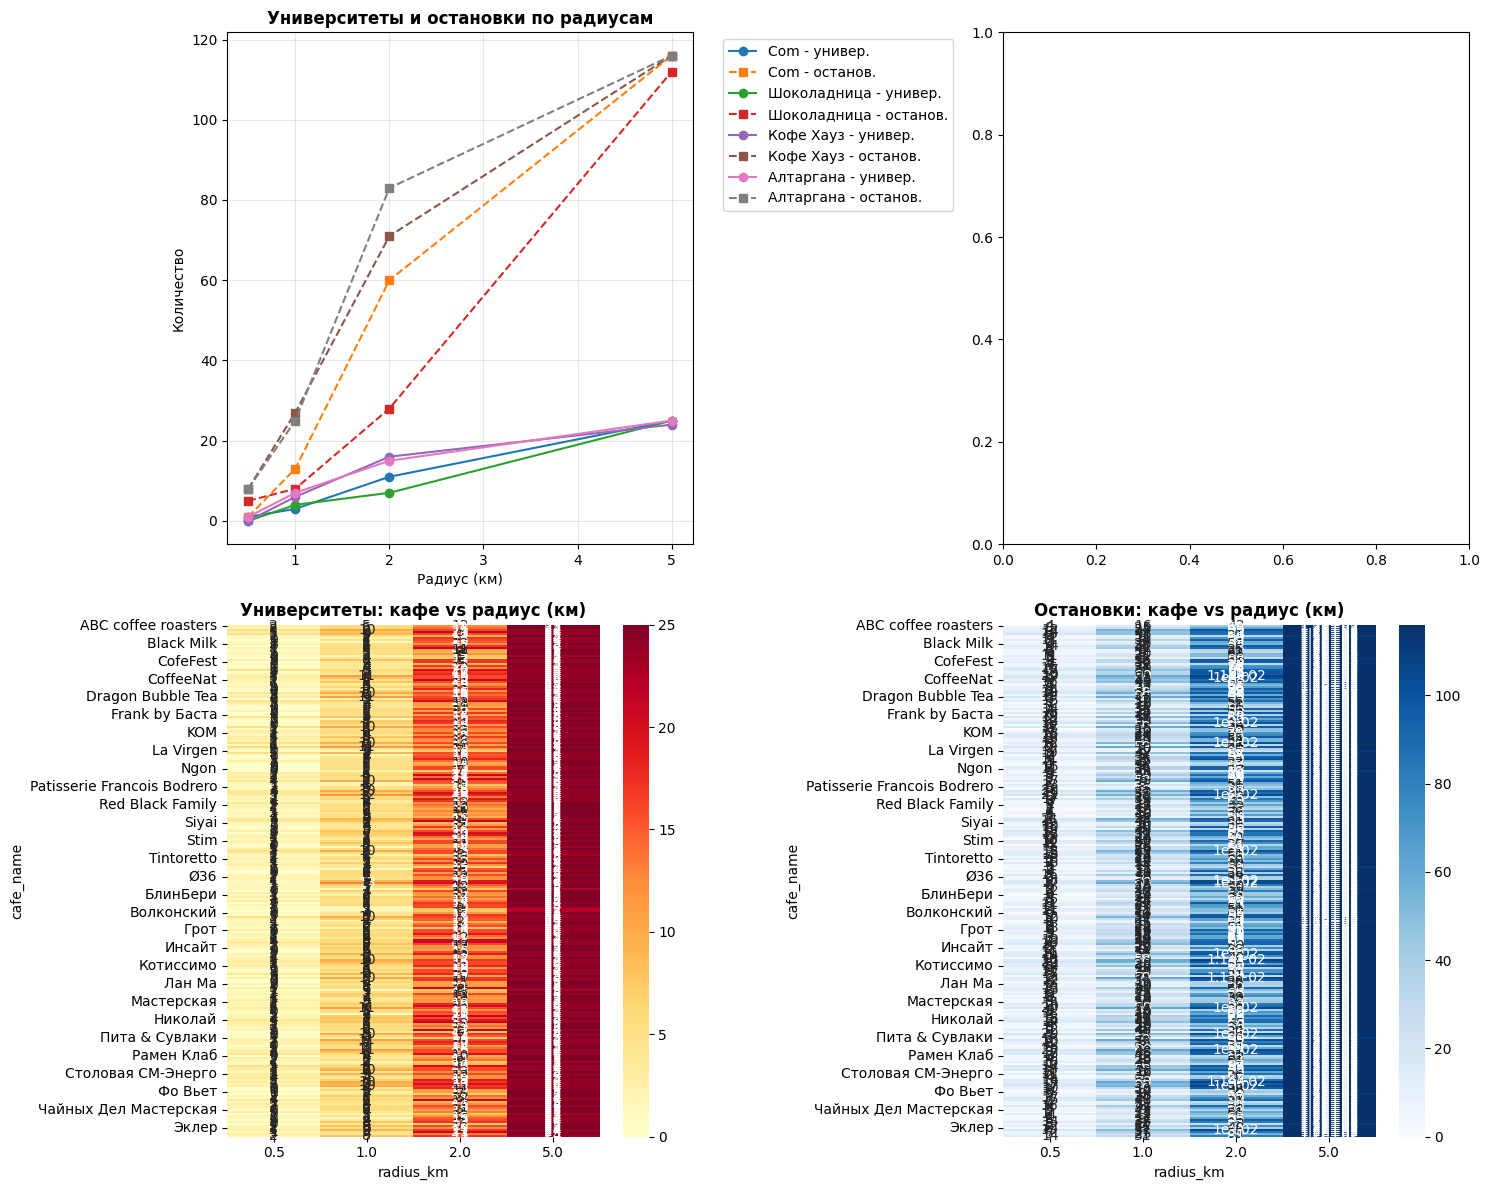

/tmp/ipython-input-2953085387.py:91: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/tmp/ipython-input-2953085387.py:91: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/tmp/ipython-input-2953085387.py:91: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/tmp/ipython-input-2953085387.py:91: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


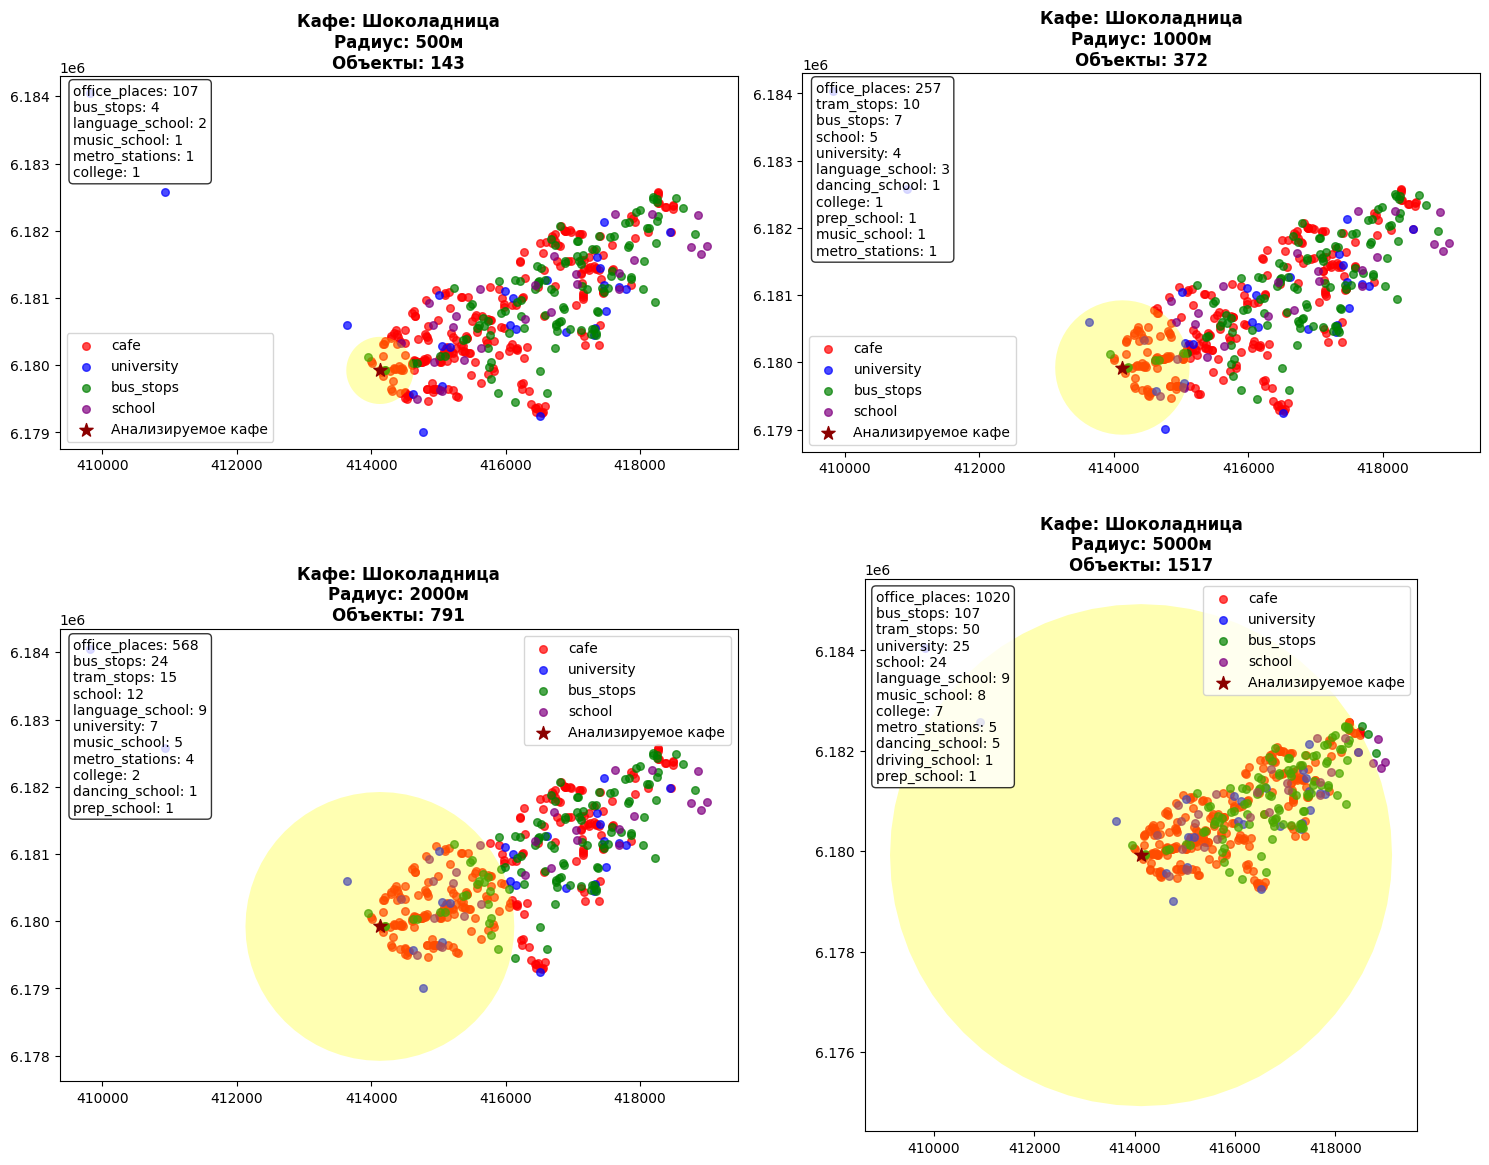

In [41]:

"""Создание визуализаций для разных радиусов"""

# 1. График изменения количества объектов с ростом радиуса
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Для каждого кафе - линии по разным типам объектов
cafe_names = radius_analysis['cafe_name'].unique()

# График 1: Университеты и остановки
for cafe in cafe_names[:4]:  # первые 4 кафе для читаемости
    cafe_data = radius_analysis[radius_analysis['cafe_name'] == cafe]
    axes[0, 0].plot(cafe_data['radius_km'], cafe_data['universities_count'],
                    marker='o', label=f'{cafe} - универ.')
    axes[0, 0].plot(cafe_data['radius_km'], cafe_data['stops_count'],
                    marker='s', linestyle='--', label=f'{cafe} - останов.')

axes[0, 0].set_title('Университеты и остановки по радиусам', fontweight='bold')
axes[0, 0].set_xlabel('Радиус (км)')
axes[0, 0].set_ylabel('Количество')
axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 0].grid(True, alpha=0.3)

# График 3: Heatmap по радиусам и кафе (университеты)
heatmap_data = radius_analysis.pivot_table(
    index='cafe_name', columns='radius_km', values='universities_count'
)
sns.heatmap(heatmap_data, annot=True, cmap='YlOrRd', ax=axes[1, 0])
axes[1, 0].set_title('Университеты: кафе vs радиус (км)', fontweight='bold')

# График 4: Heatmap по радиусам и кафе (остановки)
heatmap_data_stops = radius_analysis.pivot_table(
    index='cafe_name', columns='radius_km', values='stops_count'
)
sns.heatmap(heatmap_data_stops, annot=True, cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_title('Остановки: кафе vs радиус (км)', fontweight='bold')

plt.tight_layout()
plt.savefig('radius_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Карты с разными радиусами для выбранного кафе
# create_radius_maps()

# fig


"""Создание карт с разными радиусами для визуализации"""
# Выбираем одно кафе для демонстрации
demo_cafe = cafes_utm.iloc[1]
radii = [500, 1000, 2000, 5000]

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, radius in enumerate(radii):
    ax = axes[idx]

    # Отображаем все объекты
    types_colors = {
        'cafe': 'red', 'university': 'blue',
        'bus_stops': 'green', 'school': 'purple'
    }

    for obj_type, color in types_colors.items():
        type_data = all_objects_utm[all_objects_utm['type'] == obj_type]
        type_data.plot(ax=ax, color=color, markersize=30, label=obj_type, alpha=0.7)

    # Отображаем буферную зону
    buffer = demo_cafe.geometry.buffer(radius)
    gpd.GeoSeries([buffer]).plot(ax=ax, color='yellow', alpha=0.3,
                                label=f'Радиус {radius}м')

    # Выделяем анализируемое кафе
    cafes_utm[cafes_utm['name'] == demo_cafe['name']].plot(
        ax=ax, color='darkred', markersize=100, marker='*',
        label='Анализируемое кафе'
    )

    # Подсчет объектов в радиусе
    nearby_objects = all_objects_utm[
        all_objects_utm.geometry.within(buffer)
    ]
    counts = nearby_objects['type'].value_counts()

    ax.set_title(
        f"Кафе: {demo_cafe['name']}\n"
        f"Радиус: {radius}м\n"
        f"Объекты: {len(nearby_objects)-1}",
        fontweight='bold'
    )
    ax.legend()

    # Добавляем статистику на карту
    stats_text = "\n".join([f"{k}: {v}" for k, v in counts.items() if k != 'cafe'])
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('radius_maps_comparison.png', dpi=300, bbox_inches='tight')
plt.show()